In [15]:
import numpy as np
import pandas as pd
import krippendorff
import seaborn as sns
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm
from irrCAC.raw import CAC

tqdm.pandas()

In [16]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)
red = (168/255, 96/255, 93/255)
pale_yellow = (164/255, 168/255, 93/255)


color_palette = sns.color_palette([grey, darkgreen, teal, blue, yellow, red, pale_yellow])
sns.set_theme(style="whitegrid")


# Grade Analysis

In [17]:
def apply_group(id):
    if id in [1, 2, 3, 4]:
        return '1-4'
    elif id in [5, 6, 7, 8]:
        return '5-8'
    elif id in [9, 10, 11, 12]:
        return '9-12'
    elif id in [13, 14, 15, 16]:
        return '13-16'
    elif id in [17, 18, 19, 20]:
        return '17-20'
    elif id in [21, 22, 23, 24]:
        return '21-24'
    else:
        return '25-28'

In [18]:
grade_df = pd.read_csv('data/inter_rater.csv', index_col=0)
grade_df['grade'] = pd.Categorical(grade_df['grade'],
                                         ['A++', 'A+', 'A', 'A-',
                                          'B+', 'B', 'B-',
                                          'C+', 'C', 'C-',
                                          'D+', 'D', 'D-',
                                          'F'])

grade_df['group'] = grade_df['participant_id'].apply(apply_group)
grade_df['group'] = pd.Categorical(grade_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])


# Removed as this was accidentally duplicated
grade_df = grade_df[grade_df['assignment_number'] != 105]
grade_df = grade_df[~grade_df['grade'].isnull()]
grade_df

,assignment_number,comments,skill,participant_id,batch,grade,group
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4
4,188.0,Some method names are misleading,Readability,2,2,B,1-4
3,542.0,NaN,Readability,2,2,A-,1-4
2,277.0,NaN,Readability,2,2,A-,1-4
1,303.0,NaN,Readability,2,2,A-,1-4
...,...,...,...,...,...,...,...
3,176.0,NaN,Readability,26,1,A++,25-28
4,619.0,NaN,Readability,26,1,A-,25-28
5,305.0,NaN,Readability,26,1,A+,25-28
5,305.0,The submission includes a large number of clas...,Documentation,28,1,A++,25-28


# Inter-Rater Analysis

In [19]:
def calculate_all_reliability_metric(metric, grade_col='grade'):
    results_df = None
    
    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in grade_df['group'].unique():
            try:
                
                if metric == 'krippendorff':
                    metric_result = calculate_krippendorrf_alpha(skill, group, grade_col)
                else:
                    metric_result = calculate_ac2(skill, group, grade_col)
                
                results_df = pd.concat([results_df, pd.DataFrame({
                                        'group': group,
                                        'skill': skill,
                                        'metric_result': metric_result}, index=[0])])

                results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
            except ValueError as e:
                print('Error duplicate entries check data for: ', group)
                raise e
    
    return results_df

### Krippendorrf's Alpha

In [20]:
def merge_grades(row):
    if row[row.index[0]] >= row[row.index[1]]:
        return str(row[row.index[0]]) + str(row[row.index[1]])
    else:
        return str(row[row.index[1]]) + str(row[row.index[0]])

In [21]:
# Grades are ordinal data or just stick with nominal? Are pairs of grades still ordinal?
def calculate_krippendorrf_alpha(skill, group, grade_col):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'group', grade_col]].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df[grade_col] = group_df[grade_col].cat.codes
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values=grade_col)
    
    return krippendorff.alpha(pivot.to_numpy(), level_of_measurement='ordinal')

In [22]:
calculate_krippendorrf_alpha('Correctness', '13-16', 'grade')

0.20875490820626974

In [23]:
fine_alpha_df = calculate_all_reliability_metric('krippendorff', 'grade').sort_values(by='group')
fine_alpha_df

,group,skill,metric_result
0,1-4,Correctness,0.281601
0,1-4,Documentation,0.102318
0,1-4,Code Elegance,0.071930
0,1-4,Readability,0.034320
0,5-8,Correctness,-0.069250
0,5-8,Code Elegance,0.042380
0,5-8,Documentation,-0.101600
0,5-8,Readability,-0.110749
0,9-12,Code Elegance,0.066531
0,9-12,Documentation,0.019464


FileNotFoundError: [Errno 2] No such file or directory: 'plots/krippendorrf_fine.pdf'

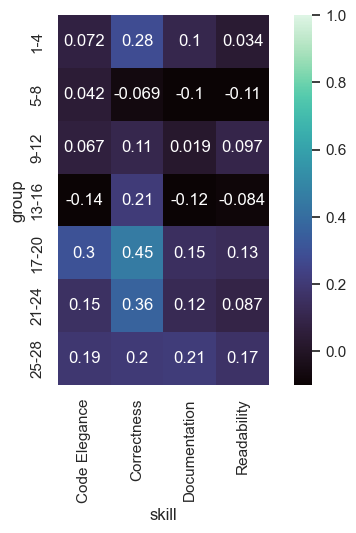

In [24]:
pivot_df = fine_alpha_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/krippendorrf_fine.pdf', bbox_inches='tight')

In [12]:
fine_alpha_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.098628
1,Correctness,0.220210
2,Documentation,0.054528
3,Readability,0.045598


In [13]:
fine_alpha_df[['group', 'metric_result']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13241/1232685465.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_alpha_df[['group', 'metric_result']].groupby('group').mean().reset_index()


,group,metric_result
0,1-4,0.122543
1,5-8,-0.059805
2,9-12,0.072266
3,13-16,-0.032394
4,17-20,0.257109
5,21-24,0.181226
6,25-28,0.192243


### Gwet's ac2

In [14]:
def calculate_ac2(skill, group, grade_col):
    skill_df = grade_df[grade_df['skill'] == skill][['participant_id', 'assignment_number', 'group', grade_col]].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df[grade_col] = group_df[grade_col].cat.codes
    # Transpose pivot to get in form required by library rater by assignment
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values=grade_col).T 
    cac = CAC(pivot, 'ordinal')

    return cac.gwet()['est']['coefficient_value']

In [15]:
calculate_ac2('Correctness', '13-16', 'grade')

0.67246

In [16]:
ac2_df = calculate_all_reliability_metric('ac2', 'grade').sort_values(by='group')
ac2_df

,group,skill,metric_result
0,1-4,Correctness,0.59829
0,1-4,Documentation,0.50856
0,1-4,Code Elegance,0.53049
0,1-4,Readability,0.54217
0,5-8,Correctness,0.58691
0,5-8,Code Elegance,0.56184
0,5-8,Documentation,0.49920
0,5-8,Readability,0.40492
0,9-12,Code Elegance,0.66729
0,9-12,Documentation,0.68618


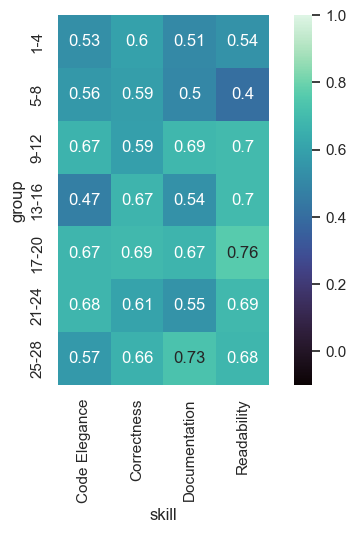

In [17]:
pivot_df = ac2_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/gwet_ac2.pdf', bbox_inches='tight')

In [18]:
ac2_df[['skill', 'metric_result']].groupby('skill').mean().reset_index()

,skill,metric_result
0,Code Elegance,0.592377
1,Correctness,0.628587
2,Documentation,0.596593
3,Readability,0.638274


In [19]:
ac2_df[['group', 'metric_result']].groupby('group').mean().reset_index()

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13241/1801375983.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ac2_df[['group', 'metric_result']].groupby('group').mean().reset_index()


,group,metric_result
0,1-4,0.544878
1,5-8,0.513217
2,9-12,0.659408
3,13-16,0.594093
4,17-20,0.698465
5,21-24,0.629850
6,25-28,0.657795


### Count of student type per group

In [11]:
demo_df = pd.read_csv('Menagerie/data/pre_study_survey.csv')
demo_df = demo_df.iloc[2:]

demo_df['group'] = demo_df['Q1'].astype(int).apply(apply_group)
demo_df['group'] = pd.Categorical(demo_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])

demo_df['Q5'] = demo_df['Q5'].str.replace('Other', "Master's Student")

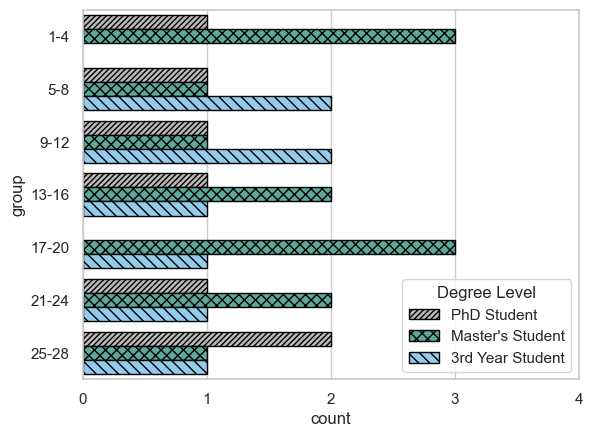

In [21]:
demo_plt = sns.countplot(demo_df, y='group', hue='Q5')
hatches = ['//', 'x', '\\']
colors = [grey, teal, blue]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, demo_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

handles = demo_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')
    
demo_plt.legend(title='Degree Level')
demo_plt.set_xticks(range(5))
demo_plt.get_figure().savefig('plots/group_degree_level.pdf', bbox_inches='tight')

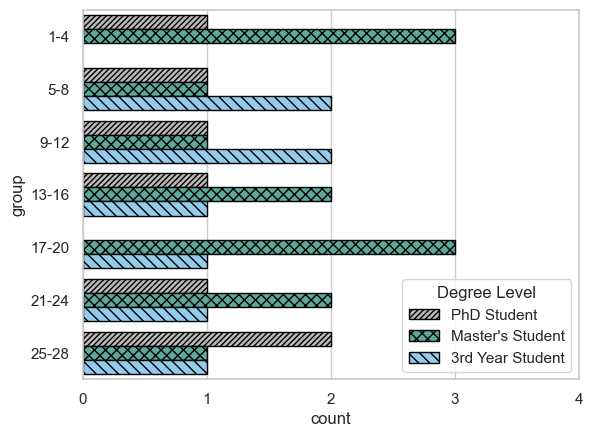

In [22]:
demo_plt = sns.countplot(demo_df, y='group', hue='Q5')
hatches = ['//', 'x', '\\']
colors = [grey, teal, blue]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, demo_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

handles = demo_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

demo_plt.legend(title='Degree Level')
demo_plt.set_xticks(range(5))
demo_plt.get_figure().savefig('plots/group_degree_level.pdf', bbox_inches='tight')

## Distance between grades

In [23]:
def get_grade(df, grade_col, group, skill, assignment_number, participant_id):
    grade = df[(df['group'] == group) &
                         (df['skill'] == skill) &
                         (df['assignment_number'] == assignment_number) &
                         (df['participant_id'] == participant_id)][grade_col]

    if grade.empty:
        return None
    return grade

In [24]:
def generate_grade_pairs(df, grade_col, group, skill, assignment_number):
    group_bounds = group.split('-')
    pairs = combinations(range(int(group_bounds[0]), int(group_bounds[1]) + 1), r=2)
    
    grade_pairs_df = None
    
    
    for idx, pair in enumerate(pairs):
        grade_1 = get_grade(df, grade_col, group, skill, assignment_number, pair[0])
        grade_2 = get_grade(df, grade_col, group, skill,assignment_number, pair[1])
    
        if grade_pairs_df is None:
            grade_pairs_df = pd.DataFrame({'group': group,
                                              'skill': skill,
                                              'assignment_number': assignment_number,
                                              'participant_id_1': pair[0],
                                              'participant_id_2': pair[1],
                                              'grade_1': grade_1,
                                              'grade_2': grade_2
                                              }, index=[idx])
        else:
            grade_pairs_df = pd.concat([
                grade_pairs_df,
                pd.DataFrame({'group': group, 'assignment_number': assignment_number, 'skill': skill,
                              'participant_id_1': pair[0],
                              'participant_id_2': pair[1],
                              'grade_1': grade_1,
                              'grade_2': grade_2
                              }, index=[idx])]
            )


    grade_pairs_df['group'] = pd.Categorical(grade_pairs_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
    return grade_pairs_df
        

In [25]:
def get_distance_df(df, grade_col):
    dist_df = None
    
    for group in tqdm(df['group'].unique()):
        for skill in df['skill'].unique():
            for n in df[(df['group'] == group) &
                               (df['skill'] == skill)]['assignment_number'].unique():
                if  dist_df is None:
                    dist_df = generate_grade_pairs(df, grade_col, group, skill, n)
                else:
                    dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
    
    dist_df = dist_df.dropna()
    dist_df['grade_1_code'] = dist_df['grade_1'].cat.codes
    dist_df['grade_2_code'] = dist_df['grade_2'].cat.codes
    dist_df['distance'] = abs(dist_df['grade_1_code'] - dist_df['grade_2_code'])
    
    return dist_df
            

#### Boxplot

##### Fine

 29%|██▊       | 2/7 [00:02<00:07,  1.42s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13241/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, group, skill, n)])
 43%|████▎     | 3/7 [00:04<00:05,  1.41s/it]/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_13241/3626878353.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_df = pd.concat([dist_df, generate_grade_pairs(df, grade_col, g

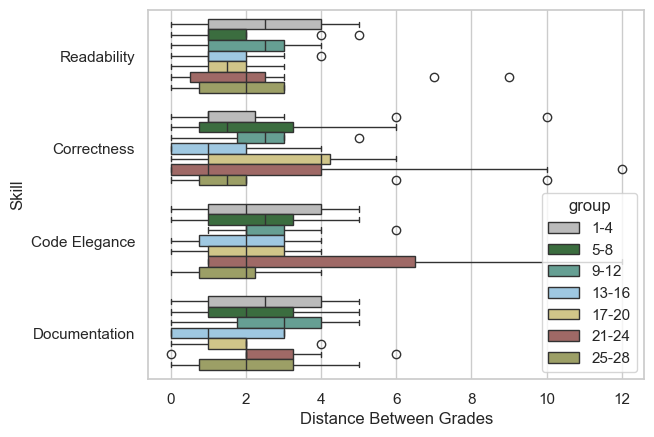

In [26]:
fine_dist_df = get_distance_df(grade_df, 'grade').sort_values(by='group')
g = sns.boxplot(fine_dist_df, y='skill', x='distance', hue='group', palette=color_palette)
g.set(xlabel='Distance Between Grades', ylabel='Skill')
g.get_figure().savefig('plots/fine_grade_distance.pdf', bbox_inches='tight')

In [27]:
fine_dist_df.groupby('skill')['distance'].mean()

skill
Code Elegance    2.385542
Correctness      2.313253
Documentation    2.162500
Readability      1.927711
Name: distance, dtype: float64

# Intra-Rater Relability

In [28]:
DUPLICATE_MAP = {
    680: 144,
    681: 559,
    682: 97,
    683: 358,
    684: 389,
    685: 160,
    686: 176
}

In [29]:
intra_rater_df = grade_df[grade_df['assignment_number'].isin(list(DUPLICATE_MAP.keys())+list(DUPLICATE_MAP.values()))][['assignment_number', 'skill', 'participant_id', 'batch', 'grade']]
intra_rater_df = intra_rater_df.sort_values('grade')
intra_rater_df

,assignment_number,skill,participant_id,batch,grade
7,680.0,Readability,3,2,A++
4,681.0,Correctness,7,2,A++
12,358.0,Correctness,14,1,A++
19,683.0,Documentation,14,2,A++
19,683.0,Correctness,14,2,A++
...,...,...,...,...,...
7,97.0,Readability,10,1,F
14,682.0,Readability,10,2,F
14,682.0,Correctness,10,2,F
14,682.0,Code Elegance,10,2,F


### Map replacement IDs to original IDs

In [30]:
intra_rater_df['assignment_number'] = intra_rater_df['assignment_number'].apply(lambda x: x if x not in DUPLICATE_MAP.keys() else DUPLICATE_MAP[x])
intra_rater_df['grade_code'] = intra_rater_df['grade'].cat.codes
intra_rater_df

,assignment_number,skill,participant_id,batch,grade,grade_code
7,144.0,Readability,3,2,A++,0
4,559.0,Correctness,7,2,A++,0
12,358.0,Correctness,14,1,A++,0
19,358.0,Documentation,14,2,A++,0
19,358.0,Correctness,14,2,A++,0
...,...,...,...,...,...,...
7,97.0,Readability,10,1,F,13
14,97.0,Readability,10,2,F,13
14,97.0,Correctness,10,2,F,13
14,97.0,Code Elegance,10,2,F,13


In [31]:
pivot = intra_rater_df.pivot(index=['assignment_number', 'skill', 'participant_id'], columns='batch', values='grade').reset_index()
pivot.columns = ['assignment_number', 'skill', 'participant_id', 'grade_1', 'grade_2']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2
0,97.0,Code Elegance,9,A-,B+
1,97.0,Code Elegance,10,F,F
2,97.0,Code Elegance,11,A-,A+
3,97.0,Code Elegance,12,A-,B
4,97.0,Correctness,9,B+,A
...,...,...,...,...,...
107,559.0,Documentation,8,A,A
108,559.0,Readability,5,A-,B+
109,559.0,Readability,6,A-,A++
110,559.0,Readability,7,A+,A+


## Distance between grade notches

In [32]:
pivot['grade_1_code'] = pivot['grade_1'].cat.codes
pivot['grade_2_code'] = pivot['grade_2'].cat.codes
pivot['distance'] = pivot['grade_1_code'] - pivot['grade_2_code']
pivot

,assignment_number,skill,participant_id,grade_1,grade_2,grade_1_code,grade_2_code,distance
0,97.0,Code Elegance,9,A-,B+,3,4,-1
1,97.0,Code Elegance,10,F,F,13,13,0
2,97.0,Code Elegance,11,A-,A+,3,1,2
3,97.0,Code Elegance,12,A-,B,3,5,-2
4,97.0,Correctness,9,B+,A,4,2,2
...,...,...,...,...,...,...,...,...
107,559.0,Documentation,8,A,A,2,2,0
108,559.0,Readability,5,A-,B+,3,4,-1
109,559.0,Readability,6,A-,A++,3,0,3
110,559.0,Readability,7,A+,A+,1,1,0


In [33]:
NOTICED_DUP = [1, 2, 10, 11, 20, 25]

In [34]:
sns.set(rc={'text.usetex': True})

def underline(input):
    return r'\underline{\textbf{%s}}' %input

underline(10)

'\\underline{\\textbf{10}}'

FileNotFoundError: [Errno 2] No such file or directory: 'plots/correctness_distance.pdf'

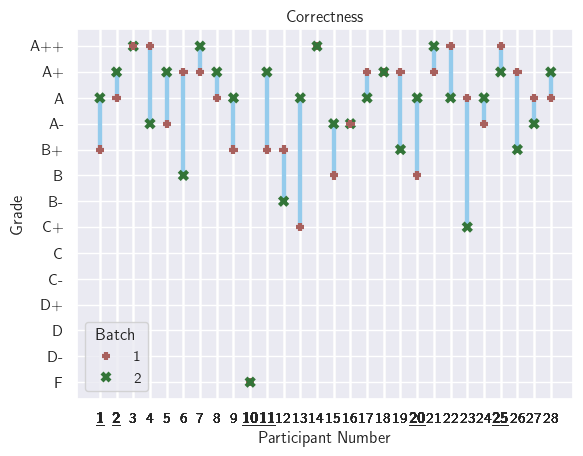

In [35]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Correctness'], x='participant_id', y='grade', style='batch', hue='batch', palette=sns.color_palette([red, darkgreen]), markers=['+', 'x'], zorder=5, lw=3)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Correctness'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Correctness') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code], lw=3)
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Correctness', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
temp_ticks = dist_plt.get_xticks()
temp_ticks = [underline(x) if x in NOTICED_DUP else x for x in temp_ticks]
dist_plt.set_xticklabels(temp_ticks)

dist_plt.get_figure().savefig('plots/correctness_distance.pdf', bbox_inches='tight')

In [ ]:
pivot[pivot['skill'] == 'Correctness']['distance'].abs().mean()

In [31]:
pivot[(pivot['skill'] == 'Correctness') & (pivot['distance'] == 0)]['participant_id']

5     10
22     3
69    14
71    16
85    18
Name: participant_id, dtype: int64

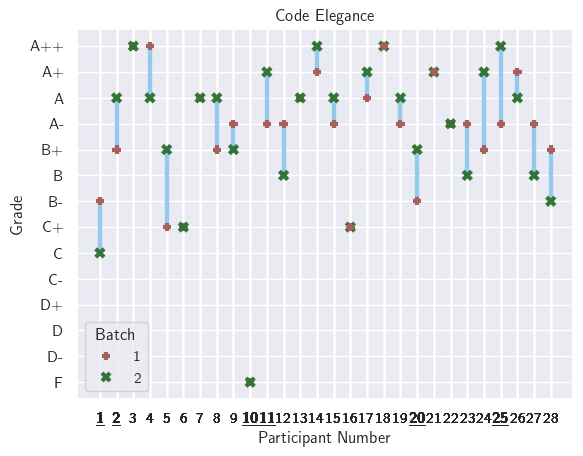

In [36]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'], x='participant_id', y='grade', style='batch', hue='batch', palette=sns.color_palette([red, darkgreen]), markers=['+', 'x'], zorder=5, lw=3)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Code Elegance'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Code Elegance') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code], lw=3)
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Code Elegance', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
temp_ticks = dist_plt.get_xticks()
temp_ticks = [underline(x) if x in NOTICED_DUP else x for x in temp_ticks]
dist_plt.set_xticklabels(temp_ticks)
dist_plt.get_figure().savefig('plots/code_elegance_distance.pdf', bbox_inches='tight')

In [ ]:
pivot[pivot['skill'] == 'Code Elegance']['distance'].abs().mean()

In [34]:
pivot[(pivot['skill'] == 'Code Elegance') & (pivot['distance'] == 0)]['participant_id']

1     10
18     3
32    21
33    22
64    13
67    16
81    18
97     6
98     7
Name: participant_id, dtype: int64

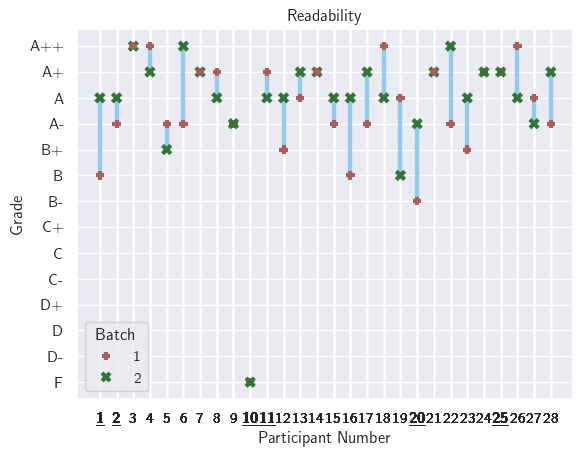

In [37]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Readability'], x='participant_id', y='grade', style='batch', hue='batch', palette=sns.color_palette([red, darkgreen]), markers=['+', 'x'], zorder=5,lw=3)

for index, row in intra_rater_df[intra_rater_df['skill'] == 'Readability'].iterrows():
    participant_id = row['participant_id']
    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']

    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Readability') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code], lw=3)
    plt.setp(line, color=blue)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Readability', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')
temp_ticks = dist_plt.get_xticks()
temp_ticks = [underline(x) if x in NOTICED_DUP else x for x in temp_ticks]
dist_plt.set_xticklabels(temp_ticks)
dist_plt.get_figure().savefig('plots/readability_distance.pdf', bbox_inches='tight')

In [36]:
pivot[pivot['skill'] == 'Readability']['distance'].abs().mean()

1.3571428571428572

In [37]:
pivot[(pivot['skill'] == 'Readability') & (pivot['distance'] == 0)]['participant_id']

12      9
13     10
30      3
44     21
47     24
60     25
77     14
110     7
Name: participant_id, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: 'plots/documentation_distance.pdf'

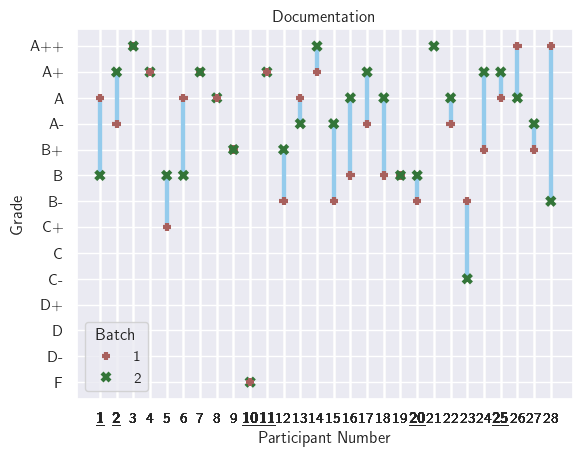

In [38]:
dist_plt = sns.scatterplot(intra_rater_df[intra_rater_df['skill'] == 'Documentation'], x='participant_id', y='grade', style='batch', hue='batch', palette=sns.color_palette([red, darkgreen]), markers=['+', 'x'], zorder=5, lw=3)


for index, row in intra_rater_df[intra_rater_df['skill'] == 'Documentation'].iterrows():
    participant_id = row['participant_id']
    
    if participant_id  == 21:
        # Participant 21 did not provide grades for documentation in the second batch
        continue
    

    grade_1_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 1)]['grade_code']
    grade_2_code = intra_rater_df[(intra_rater_df['skill'] == 'Documentation') & (intra_rater_df['participant_id'] == participant_id) & (intra_rater_df['batch'] == 2)]['grade_code']

    line = dist_plt.plot([participant_id, participant_id], [grade_1_code, grade_2_code], lw=3)
    plt.setp(line, color=blue, zorder=1)

dist_plt.set(ylabel='Grade', xlabel='Participant Number', title='Documentation', xticks=intra_rater_df['participant_id'])
dist_plt.legend(title='Batch')

temp_ticks = dist_plt.get_xticks()
temp_ticks = [underline(x) if x in NOTICED_DUP else x for x in temp_ticks]
dist_plt.set_xticklabels(temp_ticks)

dist_plt.get_figure().savefig('plots/documentation_distance.pdf', bbox_inches='tight')
sns.set(rc={'text.usetex': False})

In [39]:
pivot['distance'] = pivot['distance'].abs()
# pivot[['skill', 'distance']].groupby('skill').mean()
pivot[pivot['distance'] <=2].groupby('participant_id').count()

,assignment_number,skill,grade_1,grade_2,grade_1_code,grade_2_code,distance
participant_id,,,,,,,
1,2,2,2,2,2,2,2
2,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4
4,3,3,3,3,3,3,3
5,3,3,3,3,3,3,3
6,1,1,1,1,1,1,1
7,4,4,4,4,4,4,4
8,4,4,4,4,4,4,4
9,4,4,4,4,4,4,4


In [40]:
pivot[(pivot['skill'] == 'Documentation') & (pivot['distance'] == 0)]['participant_id']

8       9
9      10
10     11
26      3
27      4
90     19
106     7
107     8
Name: participant_id, dtype: int64

### Distance between grades by grading experience

In [41]:
experience_df = demo_df[['Q1', 'Q7', 'Q9']]
experience_df.columns = ['participant_id', 'prog_exp', 'grading_exp']
experience_df['participant_id'] = experience_df['participant_id'].astype(int)
experience_df['grading_exp'] = experience_df['grading_exp'].fillna('No grading \n experience')
experience_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_52385/1354412453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experience_df['participant_id'] = experience_df['participant_id'].astype(int)
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_52385/1354412453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experience_df['grading_exp'] = experience_df['grading_exp'].fillna('No grading \n experience')


,participant_id,prog_exp,grading_exp
2,4,5+ years,No grading \n experience
3,10,5+ years,2 - 3 years
4,18,5+ years,2 - 3 years
5,19,5+ years,0 - 1 years
6,3,5+ years,1 - 2 years
7,16,5+ years,No grading \n experience
8,24,5+ years,No grading \n experience
9,2,5+ years,No grading \n experience
10,25,5+ years,No grading \n experience
11,5,5+ years,No grading \n experience


In [44]:
exp_dist_df = pd.merge(experience_df, pivot[['participant_id', 'skill', 'distance']], on='participant_id', how='right')
exp_dist_df['distance'] = exp_dist_df['distance'].abs()
# exp_dist_df

,participant_id,prog_exp,grading_exp,skill,distance
0,9,3 - 5 years,0 - 1 years,Code Elegance,1
1,10,5+ years,2 - 3 years,Code Elegance,0
2,11,5+ years,No grading \n experience,Code Elegance,2
3,12,5+ years,No grading \n experience,Code Elegance,2
4,9,3 - 5 years,0 - 1 years,Correctness,2
...,...,...,...,...,...
107,8,3 - 5 years,0 - 1 years,Documentation,0
108,5,5+ years,No grading \n experience,Readability,1
109,6,5+ years,No grading \n experience,Readability,3
110,7,5+ years,0 - 1 years,Readability,0


In [78]:
doc_df = exp_dist_df[(exp_dist_df['grading_exp'] == 'No grading \n experience') & (exp_dist_df['skill'] == 'Documentation')]
doc_df["distance"].quantile([0.25,0.5,0.75])
(doc_df['distance'].quantile(0.75) - doc_df['distance'].quantile(0.25)) * 1.5

3.0

In [80]:
c_df = exp_dist_df[(exp_dist_df['grading_exp'] == 'No grading \n experience') & (exp_dist_df['skill'] == 'Correctness')]
c_df["distance"].quantile([0.25,0.5,0.75])
whisker = (c_df['distance'].quantile(0.75) - c_df['distance'].quantile(0.25)) * 1.5

c_df["distance"].quantile(0.75) + whisker

6.0

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_52385/3148135660.py:2: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  g_exp_box_plt = sns.boxplot(exp_dist_df, x='grading_exp', y='distance', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_palette, ax=grading_exp_plt.ax_joint)


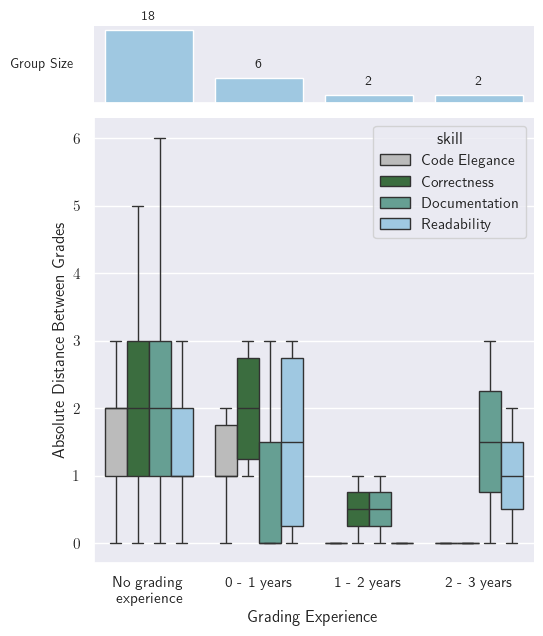

In [54]:
grading_exp_plt = sns.JointGrid()
g_exp_box_plt = sns.boxplot(exp_dist_df, x='grading_exp', y='distance', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_palette, ax=grading_exp_plt.ax_joint)
sns.countplot(experience_df, x='grading_exp', ax=grading_exp_plt.ax_marg_x, color=blue)
grading_exp_plt.ax_marg_y.remove()

g_exp_box_plt.set(xlabel='Grading Experience', ylabel='Absolute Distance Between Grades')

grading_exp_plt.ax_marg_x.set_title('Group Size', fontsize=10, loc='left', y=0.35, x=-0.19)

for p in grading_exp_plt.ax_marg_x.patches:
    grading_exp_plt.ax_marg_x.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

grading_exp_plt.savefig('plots/grading_exp_dist.pdf', bbox_inches='tight')

### Alpha by grading experience

In [44]:
experience_df['group'] = experience_df['participant_id'].apply(apply_group)
exp_alpha_df = pd.merge(experience_df, fine_alpha_df, on='group', how='right')
exp_alpha_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_30348/85209411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experience_df['group'] = experience_df['participant_id'].apply(apply_group)


,participant_id,prog_exp,grading_exp,group,skill,metric_result
0,4,5+ years,No grading \n experience,1-4,Correctness,0.281601
1,3,5+ years,1 - 2 years,1-4,Correctness,0.281601
2,2,5+ years,No grading \n experience,1-4,Correctness,0.281601
3,1,5+ years,0 - 1 years,1-4,Correctness,0.281601
4,4,5+ years,No grading \n experience,1-4,Documentation,0.102318
...,...,...,...,...,...,...
107,28,5+ years,No grading \n experience,25-28,Code Elegance,0.188966
108,25,5+ years,No grading \n experience,25-28,Documentation,0.211608
109,26,3 - 5 years,0 - 1 years,25-28,Documentation,0.211608
110,27,5+ years,No grading \n experience,25-28,Documentation,0.211608


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_30348/3830343986.py:4: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  g_inter_exp_box_plt = sns.boxplot(exp_alpha_df, x='grading_exp', y='metric_result', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_palette, ax=inter_exp_plt.ax_joint)


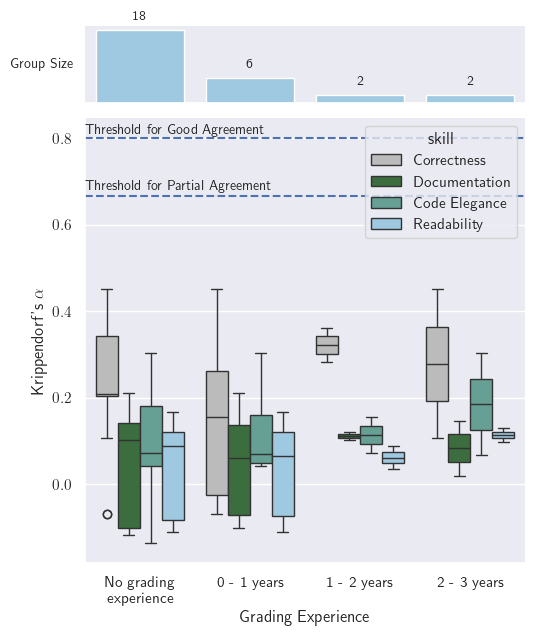

In [61]:
sns.set(rc={'text.usetex': True})

inter_exp_plt = sns.JointGrid()
g_inter_exp_box_plt = sns.boxplot(exp_alpha_df, x='grading_exp', y='metric_result', hue='skill', order=['No grading \n experience', '0 - 1 years', '1 - 2 years', '2 - 3 years'], palette=color_palette, ax=inter_exp_plt.ax_joint)
sns.countplot(experience_df, x='grading_exp', ax=inter_exp_plt.ax_marg_x, color=blue)
inter_exp_plt.ax_marg_y.remove()

g_inter_exp_box_plt.set(xlabel='Grading Experience', ylabel="Krippendorf's $\\alpha$")

inter_exp_plt.ax_marg_x.set_title('Group Size', fontsize=10, loc='left', y=0.35, x=-0.17)

inter_exp_plt.ax_joint.axhline(0.667, ls='--')
inter_exp_plt.ax_joint.axhline(0.8, ls='--')
inter_exp_plt.ax_joint.text(-0.5, 0.68, 'Threshold for Partial Agreement', fontsize=10)
inter_exp_plt.ax_joint.text(-0.5, 0.81, 'Threshold for Good Agreement', fontsize=10)

for p in inter_exp_plt.ax_marg_x.patches:
    inter_exp_plt.ax_marg_x.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

inter_exp_plt.savefig('plots/inter_exp_dist.pdf', bbox_inches='tight')
sns.set(rc={'text.usetex': False})

# Summary of Grades per skill

In [46]:
grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})
grade_count_df

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_30348/1988006025.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grade_count_df = grade_df[['skill', 'grade', 'assignment_number']].groupby(['skill', 'grade']).count().reset_index().rename(columns={'assignment_number': 'count'})


,skill,grade,count
0,Code Elegance,A++,148
1,Code Elegance,A+,197
2,Code Elegance,A,189
3,Code Elegance,A-,132
4,Code Elegance,B+,116
5,Code Elegance,B,127
6,Code Elegance,B-,73
7,Code Elegance,C+,53
8,Code Elegance,C,21
9,Code Elegance,C-,13


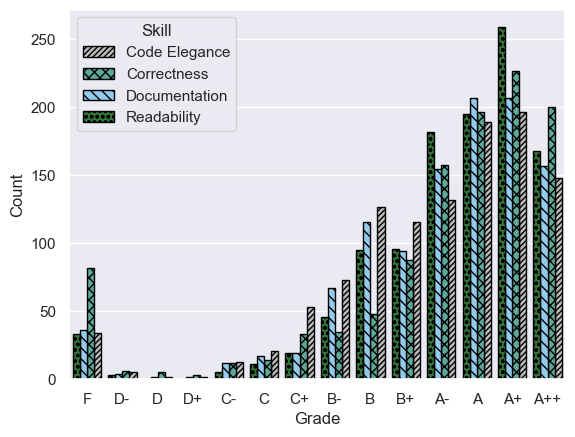

In [47]:
grade_plt = sns.barplot(x='grade', y='count', data=grade_count_df, hue='skill')

hatches = ['//', 'x', '\\', 'o']
colors = [grey, teal, blue, darkgreen]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, grade_plt.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

grade_plt.set(xlabel='Grade', ylabel='Count')
handles = grade_plt.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')


grade_plt.legend(title='Skill')
grade_plt.invert_xaxis()
grade_plt.get_figure().savefig('plots/grade_count.pdf', bbox_inches='tight')

In [48]:
lower_b = grade_count_df[~grade_count_df['grade'].isin(['A++', 'A+', 'A', 'A-', 'B+', 'B', 'B-'])]['count'].sum()

(lower_b / grade_count_df['count'].sum()) * 100

10.119719900609894

## Grades per assignment

In [49]:
per_assignment_df = grade_df[['assignment_number', 'participant_id', 'skill', 'grade', 'group']].copy()
per_assignment_df['grade_code'] = per_assignment_df['grade'].cat.codes
per_assignment_df['assignment_number'] = per_assignment_df['assignment_number'].astype('int64')

per_assignment_df

,assignment_number,participant_id,skill,grade,group,grade_code
0,302,3,Readability,A++,1-4,0
4,188,2,Readability,B,1-4,5
3,542,2,Readability,A-,1-4,3
2,277,2,Readability,A-,1-4,3
1,303,2,Readability,A-,1-4,3
...,...,...,...,...,...,...
3,176,26,Readability,A++,25-28,0
4,619,26,Readability,A-,25-28,3
5,305,26,Readability,A+,25-28,1
5,305,28,Documentation,A++,25-28,0


In [50]:
grade_code_dict = {k:v for k, v in dict(enumerate(per_assignment_df['grade'].cat.categories)).items()}
grade_code_dict

{0: 'A++',
 1: 'A+',
 2: 'A',
 3: 'A-',
 4: 'B+',
 5: 'B',
 6: 'B-',
 7: 'C+',
 8: 'C',
 9: 'C-',
 10: 'D+',
 11: 'D',
 12: 'D-',
 13: 'F'}

In [51]:
def plot_grade_per_assignment(skill, group):
    a4_dims = (8.4, 10.7)
    fig, ax = plt.subplots(figsize=a4_dims)

    data = per_assignment_df[(per_assignment_df['skill'] == skill) & (per_assignment_df['group'] == group)]
    range_df = abs(data[['assignment_number', 'grade_code']].groupby(['assignment_number']).min().dropna() - data[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna()).reset_index()
    range_df.columns = ['assignment_number', 'range']

    data = data.merge(range_df, on='assignment_number', how='left')
    data['assignment_number'] = pd.Categorical(data['assignment_number'])
    plot_order = data.sort_values(by='range', ascending=False)['assignment_number'].values
    
    ax = sns.pointplot(data, x='grade_code', y='assignment_number',
                       markers='d', markersize=4, linestyle='None', order=plot_order,
                       errorbar=lambda x: (x.min(), x.max()), err_kws=({'alpha': 0.5}), capsize=.5
                       )
    ax.set_xticks(range(len(grade_code_dict)))
    
    labels = [grade_code_dict[i] for i in range(len(ax.get_xticklabels())) if i in grade_code_dict.keys()]

    ax.set_xticklabels(labels)
    ax.set_xlabel('Grade')
    ax.set_ylabel('Assignment Number')
    ax.set_title(f'Skill = {skill} - Group = {group}')
    ax.invert_xaxis()
    
    ax.get_figure().savefig(f'plots/grade_per_assignment/grade_per_assignment_{skill}_{group}.pdf', bbox_inches='tight')
    plt.close(ax.get_figure())

plot_grade_per_assignment('Correctness', '1-4')

In [52]:
for skill in per_assignment_df['skill'].unique():
    for group in per_assignment_df['group'].unique():
        plot_grade_per_assignment(skill, group)

## Good, medium and bad grading

In [53]:
range_df = abs(per_assignment_df[['skill', 'assignment_number', 'grade_code']].groupby(['skill', 'assignment_number']).min().dropna() - per_assignment_df[['assignment_number', 'grade_code']].groupby(['assignment_number']).max().dropna())
range_df.columns = ['range']
range_df

range
skill         assignment_number       
Code Elegance 2                      8
              6                      2
              8                      5
              9                      4
              10                    12
...                                ...
Readability   682                   11
              683                    6
              684                    4
              685                    9
              686                    5

[1112 rows x 1 columns]

In [54]:
def grade_bucket(grade_dist):
    if grade_dist <= 2:
        return 'Good \n (Grade Range <= 2)'
    elif grade_dist == 3:
        return 'Mediocre \n (Grade Range = 3)'
    else:
        return 'Poor \n (Grade Range > 3)'

range_df['Grading Reliability'] = range_df['range'].map(grade_bucket)
range_df

range         Grading Reliability
skill         assignment_number                                   
Code Elegance 2                      8   Poor \n (Grade Range > 3)
              6                      2  Good \n (Grade Range <= 2)
              8                      5   Poor \n (Grade Range > 3)
              9                      4   Poor \n (Grade Range > 3)
              10                    12   Poor \n (Grade Range > 3)
...                                ...                         ...
Readability   682                   11   Poor \n (Grade Range > 3)
              683                    6   Poor \n (Grade Range > 3)
              684                    4   Poor \n (Grade Range > 3)
              685                    9   Poor \n (Grade Range > 3)
              686                    5   Poor \n (Grade Range > 3)

[1112 rows x 2 columns]

In [55]:
grade_quality_df = pd.merge(range_df, per_assignment_df, how='outer', on=['assignment_number', 'skill'])[['skill', 'grade', 'Grading Reliability']]

In [56]:
# Modified from: https://stackoverflow.com/questions/69846902/how-to-plot-stacked-100-bar-plot-with-seaborn-for-categorical-data

def plot_grade_relability(skill):
    distribution = pd.crosstab(grade_quality_df[grade_quality_df['skill'] == skill]['grade'], grade_quality_df[grade_quality_df['skill'] == skill]['Grading Reliability'], normalize='index')
    
    rel_plot = sns.barplot(data=distribution.cumsum(axis=1).stack().reset_index(name='Proportion'),
                    x='grade', y='Proportion', hue='Grading Reliability',
                    hue_order = distribution.columns[::-1],   # reverse hue order so that the taller bars got plotted first
                    dodge=False, legend=skill=='Code Elegance'
                )
    rel_plot.set(xlabel='Grade', title=f'Skill = {skill}')
    rel_plot.invert_xaxis()
    
    hatches = ['//', 'x', '\\']
    colors = ['red', 'orange', 'green']
    styles = zip(hatches, colors)
    
    
    for style, these_bars in zip(styles, rel_plot.containers):
        for this_bar in these_bars:
            this_bar.set_hatch(3 * style[0])
            this_bar.set_facecolor(style[1])
            this_bar.set_edgecolor('black')
    
    if skill == 'Code Elegance':
        handles = rel_plot.get_legend_handles_labels()[0]
        
        for i in range(len(handles)):
            handles[i].set_facecolor(colors[i])
            handles[i].set_hatch(3 * hatches[i])
            handles[i].set_edgecolor('black')
    
        rel_plot.legend(title='Grading Reliability')

        sns.move_legend(rel_plot, 'upper right')
    
    rel_plot.get_figure().savefig(f'plots/grade_reliability_{skill}.pdf', bbox_inches='tight')
    plt.close(rel_plot.get_figure())
    
for skill in grade_quality_df['skill'].unique():
    plot_grade_relability(skill)